In [135]:
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,classification_report,accuracy_score,f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split,GridSearchCV
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import time
import numpy as np
import seaborn as sns
from statistics import mean
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.datasets import make_classification


## Processing Data

In [156]:
df = pd.read_csv ('ProcessedDataset.csv', sep=',')
df.columns = df.columns.str.strip()
df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)





label_encoder = LabelEncoder()
df['proto'] = label_encoder.fit_transform(df['proto'])
df['tag'] = label_encoder.fit_transform(df['tag'])
df['rtag'] = label_encoder.fit_transform(df['rtag'])



malicious_count = df['malicious'].value_counts()[True]
non_malicious_count = df['malicious'].value_counts()[False]
print(non_malicious_count)
print (malicious_count )
print(non_malicious_count / (malicious_count + non_malicious_count ))


df = df.drop(df[df['malicious'] == True].sample(frac=0.9,random_state=40).index)
malicious_count = df['malicious'].value_counts()[True]
non_malicious_count = df['malicious'].value_counts()[False]
print(non_malicious_count)
print (malicious_count )
print(non_malicious_count / (malicious_count + non_malicious_count ))


malicious_count = df['malicious'].value_counts()[True]
non_malicious_count = df['malicious'].value_counts()[False]
smote = SMOTE(random_state=42)

X = df.drop(columns=['malicious',])
y = df['malicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Apply SMOTE to the training data only
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMOTE:", pd.Series(y_smote).value_counts())

271
65541
0.004117790068680484
271
6554
0.039706959706959706
Class distribution before SMOTE: malicious
True     4598
False     179
Name: count, dtype: int64
Class distribution after SMOTE: malicious
True     4598
False    4598
Name: count, dtype: int64


## Training Multiple Models

#### Performing Hyperparameter Tuning

In [137]:
rf = RandomForestClassifier(random_state=42)
n_estimators = [int(x) for x in range(10, 100, 10)]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [int(x) for x in range(5, 55, 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_smote, y_smote)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 5, 7],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90]},
                   random_state=42, verbose=2)

In [138]:
print(rf_random.best_params_)

{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 25, 'bootstrap': False}


### Training a Random Forest Model

In [168]:
srf = RandomForestClassifier(n_estimators=50, random_state=42,bootstrap= False, min_samples_split= 2,min_samples_leaf=3,max_depth= 25)
srf.fit(X_smote, y_smote)

RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_leaf=3,
                       n_estimators=50, random_state=42)

### Training a Balanced Random Forest Model

In [148]:
brf = BalancedRandomForestClassifier(n_estimators=50, random_state=42,bootstrap= False, min_samples_split= 2,min_samples_leaf=3,max_depth= 25,sampling_strategy='all',replacement=True)
brf.fit(X_smote, y_smote)

BalancedRandomForestClassifier(bootstrap=False, max_depth=25,
                               min_samples_leaf=3, n_estimators=50,
                               random_state=42, replacement=True,
                               sampling_strategy='all')

### Training a Logistical Regression Model

In [163]:
###Logistic regression "cheats" on protocol so we remove it ahead of time
logisticRegressionSMOTE=X_smote.drop(columns=['proto'])
logisticRegressionX_test=X_test.drop(columns=['proto'])

logisticalRegression = LogisticRegression(max_iter=1000,random_state=62, n_jobs=15, fit_intercept=True)
logisticalRegression.fit(logisticRegressionSMOTE, y_smote)

LogisticRegression(max_iter=1000, n_jobs=15, random_state=62)

### Evaluating Each Model

### Random Forests

0.99951171875


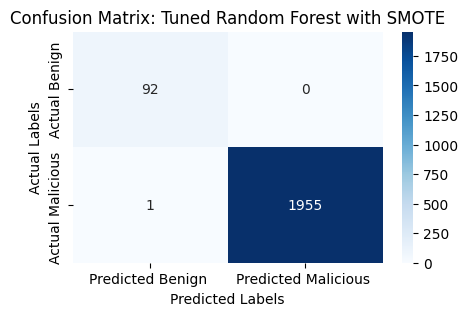

              precision    recall  f1-score   support

       False       0.99      1.00      0.99        92
        True       1.00      1.00      1.00      1956

    accuracy                           1.00      2048
   macro avg       0.99      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048



(92, 0, 1, 1955)

In [169]:
y_pred_test_srf = srf.predict(X_test)
print(accuracy_score(y_test, y_pred_test_srf ))
cm=confusion_matrix(y_test, y_pred_test_srf)
plt.figure(figsize=(5 ,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Benign ', 'Predicted Malicious '],
            yticklabels=['Actual Benign', 'Actual Malicious '])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix: Tuned Random Forest with SMOTE')
plt.show()
print(classification_report(y_test, y_pred_test_srf))
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

### Balanced Random Forests

0.99951171875


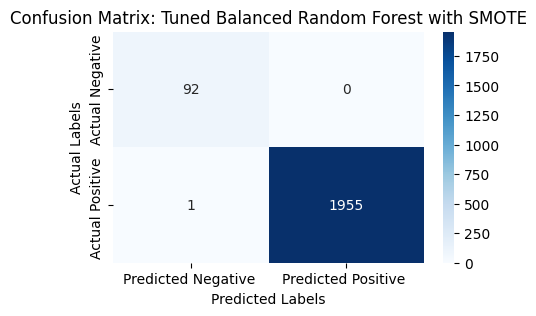

              precision    recall  f1-score   support

       False       0.99      1.00      0.99        92
        True       1.00      1.00      1.00      1956

    accuracy                           1.00      2048
   macro avg       0.99      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048



In [149]:
y_pred_test_brf = brf.predict(X_test)
print(accuracy_score(y_test, y_pred_test_brf ))
cm=confusion_matrix(y_test, y_pred_test_brf)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative ', 'Predicted Positive '],
            yticklabels=['Actual Negative', 'Actual Positive '])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix: Tuned Balanced Random Forest with SMOTE')
plt.show()
print(classification_report(y_test, y_pred_test_brf))

### Logistical Regression

0.84619140625


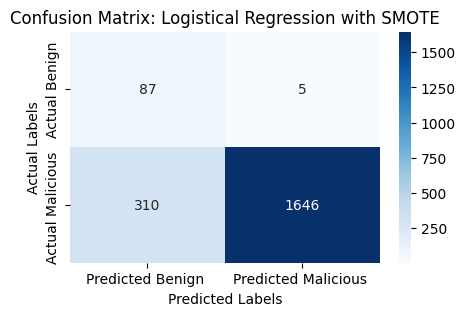

              precision    recall  f1-score   support

       False       0.22      0.95      0.36        92
        True       1.00      0.84      0.91      1956

    accuracy                           0.85      2048
   macro avg       0.61      0.89      0.63      2048
weighted avg       0.96      0.85      0.89      2048



In [165]:
y_pred_test_lrm = logisticalRegression.predict(logisticRegressionX_test)
print(accuracy_score(y_test, y_pred_test_lrm ))
cm=confusion_matrix(y_test, y_pred_test_lrm)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Benign ', 'Predicted Malicious '],
            yticklabels=['Actual Benign', 'Actual Malicious '])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix: Logistical Regression with SMOTE')
plt.show()
print(classification_report(y_test, y_pred_test_lrm))

## Checking the importance of each feature for the forests model

### Random Forests

Elapsed time to compute the importances: 0.015 seconds


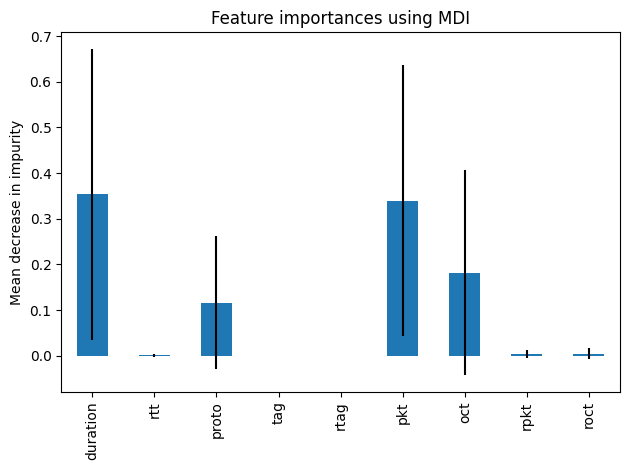

In [170]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns

start_time = time.time()
importances = srf.feature_importances_
std = np.std([tree.feature_importances_ for tree in srf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

rf_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Balanced Random Forests

Elapsed time to compute the importances: 0.007 seconds


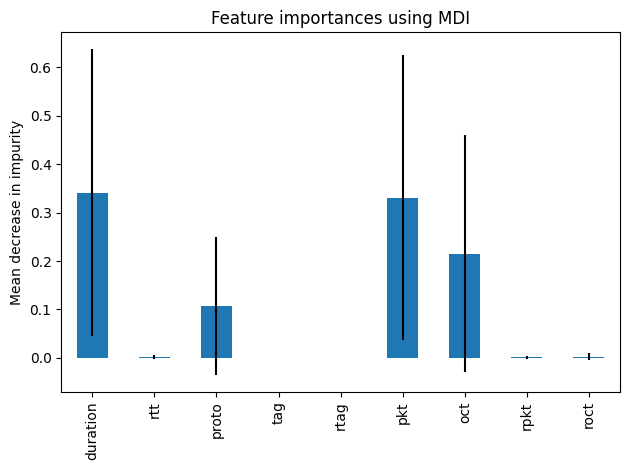

In [134]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns

start_time = time.time()
importances = brf.feature_importances_
std = np.std([tree.feature_importances_ for tree in brf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

rf_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<Axes: ylabel='Feature'>

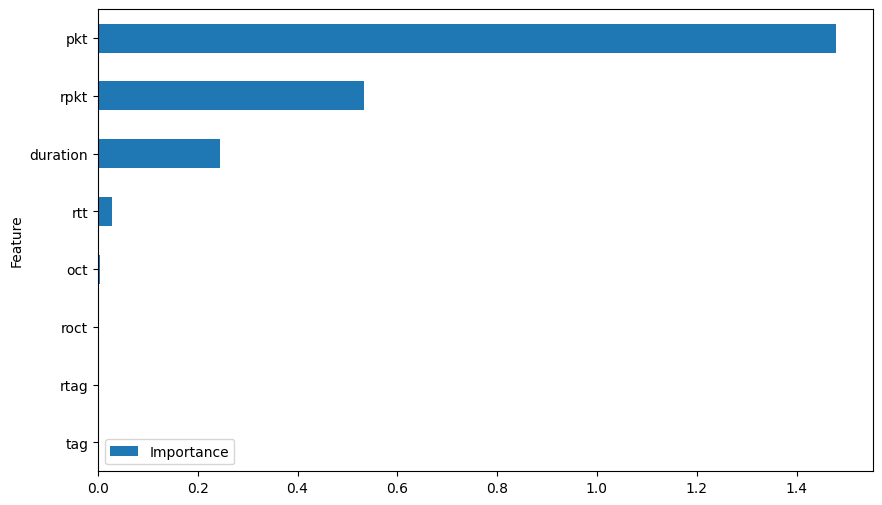

In [167]:
coefficients = logisticalRegression.coef_[0]

feature_importance = pd.DataFrame({'Feature': logisticRegressionSMOTE.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [171]:
with open('trained_model.pkl', 'wb') as model_file:
    pickle.dump(srf, model_file)

# Saving the label encoder to a file
with open('label_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)